# Support Vector Machines (SVM) Lab

**Course:** BINF 4211: Applied Data Mining for Bioinformatics

**Goals:**
- Learn how SVMs work (geometrically + practically),
- Learn how to train/evaluate them correctly for bioinformatics-style datasets (small *n*, large *d*).


## What you will do
1. Build intuition for the **maximum-margin** idea (linear SVM)
2. Train a linear SVM on a high-dimensional dataset
3. Train an RBF-kernel SVM and tune hyperparameters (**C** and **gamma**)
4. Evaluate with confusion matrix, ROC, PR curve
5. Learn best practices: scaling, leakage avoidance, and model selection


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report,
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.decomposition import PCA

np.random.seed(7)

## Part 1 — Create a toy dataset and train an SVM model to build intuition

In [2]:
X, y = make_classification(
    n_samples=40,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    weights=[0.5, 0.5],
    class_sep=1.0,
    flip_y=0.03,
    random_state=7
)

print('X shape:', X.shape)
print('Class balance:', np.bincount(y))

X shape: (40, 2)
Class balance: [22 18]


In [3]:
# check X and y
print('X:')
print(X[:5, :])

print('\ny:')
print(y[:5])

X:
[[-1.34211899 -1.46970079]
 [-0.71971171 -0.75826779]
 [-1.22165323  0.77473841]
 [ 1.22272811 -1.86853045]
 [-2.71902266 -0.49958064]]

y:
[0 0 0 1 0]


Text(0.5, 0, '$x_2$')

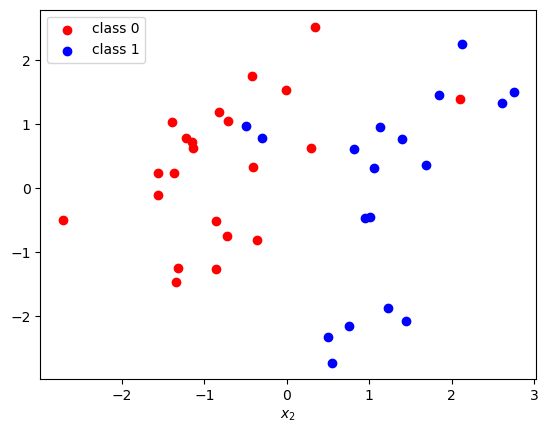

In [4]:
# plot whole simulated data
fig, ax = plt.subplots()
tf = (y==0)
ax.scatter(X[tf, 0], X[tf, 1], c='red', label='class 0')
tf = (y==1)
ax.scatter(X[tf, 0], X[tf, 1], c='blue', label='class 1')
ax.legend()
ax.set_xlabel(r'$x_1$')
ax.set_xlabel(r'$x_2$')

In [5]:
# split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=7
)

print('Train:', X_train.shape, ' Test:', X_test.shape)

Train: (30, 2)  Test: (10, 2)


In [6]:
# Train a SVM model
my_C = 0.001 # 1.0
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=my_C))
])
svm_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('svm', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",0.001
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'linear'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'


In [7]:
# check the coefficients and intercept
w1 = svm_pipeline.named_steps['svm'].coef_[0][0]
w2 = svm_pipeline.named_steps['svm'].coef_[0][1]
b = svm_pipeline.named_steps['svm'].intercept_[0]
print(w1, w2, b)

0.01626002628034312 -0.0032521366740611637 -0.9824296336054104


In [8]:
# check support vectors
print('indices of support vectors:')
print(svm_pipeline.named_steps['svm'].support_)

print('\nsupport vectors:')
support_vectors = svm_pipeline.named_steps['svm'].support_vectors_
print(support_vectors)

print('\nNum of support vectors:')
print(svm_pipeline.named_steps['svm'].n_support_)

indices of support vectors:
[ 3  4  9 10 13 16 20 21 22 23 27 28 29  0  5  6  7  8 11 14 15 17 18 19
 25 26]

support vectors:
[[-1.10572739 -1.05304697]
 [-0.07191046  1.09936661]
 [-0.73839566 -1.06693289]
 [-0.62407811  0.72674779]
 [-0.39211109  0.17010848]
 [-0.95470299  0.40016066]
 [-0.71162473  0.8274393 ]
 [-0.74393076 -0.48527647]
 [-0.39851252  1.26423008]
 [-1.11816893 -1.22276774]
 [-0.63156696 -0.67282069]
 [ 1.57046401  0.98233185]
 [ 0.16065856  0.39149829]
 [ 0.67332478 -0.44701521]
 [ 1.0213814   0.49880349]
 [ 1.97272759  0.93462656]
 [ 1.24913441  0.19486072]
 [-0.30024725  0.52158799]
 [-0.45588888  0.665383  ]
 [ 0.88704489 -1.53106831]
 [ 1.5915302   1.65566694]
 [ 0.3265597  -1.88431913]
 [ 2.08387952  1.07602036]
 [ 0.52546794 -1.75995076]
 [ 0.35543954 -2.19517205]
 [ 0.5700654   0.37947804]]

Num of support vectors:
[13 13]


In [9]:
# get the standardized data for plotting
scaler = svm_pipeline.named_steps['scaler']
X_train_scaled = scaler.transform(X_train)

In [10]:
# show that the support vectors extracted from the scaled training data is exactly what the svm model contains
print(X_train_scaled[svm_pipeline.named_steps['svm'].support_, :])

[[-1.10572739 -1.05304697]
 [-0.07191046  1.09936661]
 [-0.73839566 -1.06693289]
 [-0.62407811  0.72674779]
 [-0.39211109  0.17010848]
 [-0.95470299  0.40016066]
 [-0.71162473  0.8274393 ]
 [-0.74393076 -0.48527647]
 [-0.39851252  1.26423008]
 [-1.11816893 -1.22276774]
 [-0.63156696 -0.67282069]
 [ 1.57046401  0.98233185]
 [ 0.16065856  0.39149829]
 [ 0.67332478 -0.44701521]
 [ 1.0213814   0.49880349]
 [ 1.97272759  0.93462656]
 [ 1.24913441  0.19486072]
 [-0.30024725  0.52158799]
 [-0.45588888  0.665383  ]
 [ 0.88704489 -1.53106831]
 [ 1.5915302   1.65566694]
 [ 0.3265597  -1.88431913]
 [ 2.08387952  1.07602036]
 [ 0.52546794 -1.75995076]
 [ 0.35543954 -2.19517205]
 [ 0.5700654   0.37947804]]


In [ ]:
# prepare information for plotting the decision boundary
tf = (y_train==0)
x1_class_0_mean = X_train_scaled[tf, 0].mean()
print(x1_class_0_mean)
tf = (y_train==1)
x1_class_1_mean = X_train_scaled[tf, 0].mean()
print(x1_class_1_mean)

# for plotting the decision boundary
x2_class_0_mean = (-b - w1 * x1_class_0_mean ) / w2
x2_class_1_mean = (-b - w1 * x1_class_1_mean ) / w2
print(x2_class_0_mean)
print(x2_class_1_mean)

# for plotting the upper buffer boundary
x2_class_0_mean_upper = (1.0 + (-1.0) * b - w1 * x1_class_0_mean ) / w2
x2_class_1_mean_upper = (1.0 + (-1.0) * b - w1 * x1_class_1_mean ) / w2

# # for plotting the lower buffer boundary
x2_class_0_mean_lower = (-1.0 + (-1.0) * b - w1 * x1_class_0_mean ) / w2
x2_class_1_mean_lower = (-1.0 + (-1.0) * b - w1 * x1_class_1_mean ) / w2

In [12]:
def plot_svm_boundary_scaled(pipeline, X_train, y_train, pad=0.5, grid_step=0.02):
    """
    Plots decision boundary in the *scaled feature space*.

    Assumes pipeline has:
      - pipeline.named_steps['scaler'] (e.g., StandardScaler)
      - pipeline.named_steps['svm'] (e.g., SVC)
    and that X_train has exactly 2 features (for plotting).
    """
    scaler = pipeline.named_steps['scaler']
    svm = pipeline.named_steps['svm']

    # 1) Scale training data for plotting
    Xs = scaler.transform(X_train)

    # 2) Mesh grid in scaled space
    x_min, x_max = Xs[:, 0].min() - pad, Xs[:, 0].max() + pad
    y_min, y_max = Xs[:, 1].min() - pad, Xs[:, 1].max() + pad
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, grid_step),
        np.arange(y_min, y_max, grid_step)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # 3) Evaluate decision function on grid
    # decision_function > 0 -> predicted +1 class (for binary)
    Z = svm.decision_function(grid).reshape(xx.shape)

    # 4) Plot points
    plt.figure()
    plt.scatter(Xs[:, 0], Xs[:, 1], c=y_train)

    # Decision boundary (0) and margins (-1, +1)
    plt.contour(xx, yy, Z, levels=[-1, 0, 1])

    # Highlight support vectors (already in scaled space)
    plt.scatter(
        svm.support_vectors_[:, 0],
        svm.support_vectors_[:, 1],
        s=200,
        facecolors='none',
        edgecolors='k'
    )

    plt.xlabel("Feature 1 (scaled)")
    plt.ylabel("Feature 2 (scaled)")
    plt.title("SVM decision boundary in scaled space")

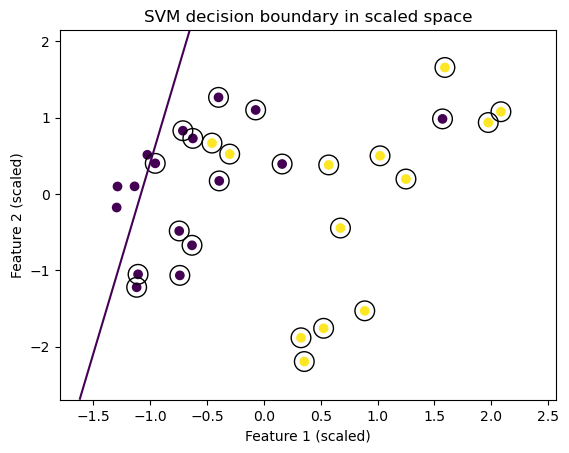

In [14]:
plot_svm_boundary_scaled(svm_pipeline, X_train, y_train)

In [15]:
from sklearn.inspection import DecisionBoundaryDisplay

def plot_training_data_with_decision_boundary(
    clf, pad=0.5, ax=None, long_title=True, support_vectors=True
):

    # Settings for plotting
    if ax is None:
        _, ax = plt.subplots(figsize=(4, 3))
    x_min, x_max, y_min, y_max = -3, 3, -3, 3
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Plot decision boundary and margins
    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.3,
    )
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="decision_function",
        plot_method="contour",
        levels=[-1, 0, 1],
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
    )

    if support_vectors:
        # Plot bigger circles around samples that serve as support vectors
        ax.scatter(
            clf.support_vectors_[:, 0],
            clf.support_vectors_[:, 1],
            s=150,
            facecolors="none",
            edgecolors="k",
        )

    # Plot samples by color and add legend
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors="k")
    # ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    ax.legend(loc="upper right", title="Classes")
    if long_title:
        ax.set_title(f" Decision boundaries in SVC")
    else:
        ax.set_title('linear')

    if ax is None:
        plt.show()

/var/folders/_n/kpln33r130b1_v5jg2xdh7xh0000gp/T/ipykernel_2100/2326767000.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right", title="Classes")


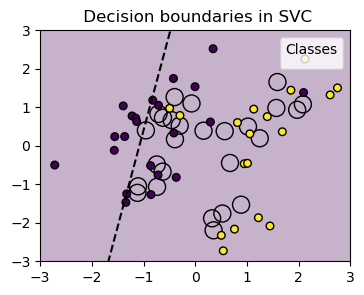

In [16]:
plot_training_data_with_decision_boundary(svm_pipeline.named_steps['svm'])

NameError: name 'x1_class_0_mean' is not defined

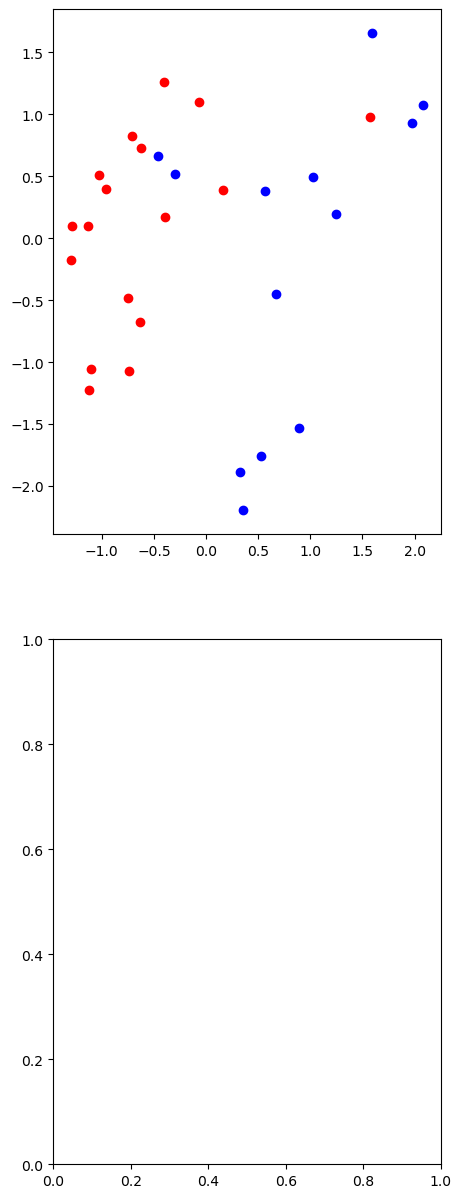

In [13]:
# plot the training data, the hyperplane, and the support vectors

fig, axs = plt.subplots(2, 1, figsize=(5, 15))

# =================
# subplot 1
# =================
tf = (y_train==0)
axs[0].scatter(X_train_scaled[tf, 0], X_train_scaled[tf, 1], c='red', label='class 0')
tf = (y_train==1)
axs[0].scatter(X_train_scaled[tf, 0], X_train_scaled[tf, 1], c='blue', label='class 1')

# decision boundary
axs[0].plot([x1_class_0_mean, x1_class_1_mean], [x2_class_0_mean, x2_class_1_mean], color='green', label=r'$w^Tx + b=0$')

# w: orthogonal to the hyperplane
# axs[0].plot([0, w1], [0, w2], color='magenta', label=r'$w$')
#
# # axs[0].set_aspect('equal')
# axs[0].set_xlabel('x1')
# axs[0].set_ylabel('x2')
# axs[0].legend()

# =================
# subplot 2
# =================
tf = (y_train==0)
axs[1].scatter(X_train_scaled[tf, 0], X_train_scaled[tf, 1], c='red', label='class 0')
tf = (y_train==1)
axs[1].scatter(X_train_scaled[tf, 0], X_train_scaled[tf, 1], c='blue', label='class 1')

# decision boundary
axs[1].plot([x1_class_0_mean, x1_class_1_mean], [x2_class_0_mean, x2_class_1_mean], color='green', label=r'$w^Tx + b=0$')

# w: orthogonal to the hyperplane
axs[1].plot([0, w1], [0, w2], color='magenta', label=r'$w$')

# upper buffer boundary
axs[1].plot([x1_class_0_mean, x1_class_1_mean], [x2_class_0_mean_upper, x2_class_1_mean_upper], \
            color='green', label=r'$w^Tx + b=+1$')

# lower buffer boundary
axs[1].plot([x1_class_0_mean, x1_class_1_mean], [x2_class_0_mean_lower, x2_class_1_mean_lower], \
            color='red', label=r'$w^Tx + b=-1$')

# support vectors
axs[1].scatter(support_vectors[:, 0], support_vectors[:, 1], c='cyan', label='support vectors')

# axs[0].set_aspect('equal')
axs[1].set_xlabel('x1')
axs[1].set_ylabel('x2')
axs[1].legend()

## Part 1 — Create a bioinformatics-style dataset
Bioinformatics often looks like:
- **small n** (patients) and **large p** (genes/metabolites)
- noisy features
- correlated features
- mild class imbalance

We'll simulate something realistic.


In [ ]:
X, y = make_classification(
    n_samples=120,          # small number of patients
    n_features=2000,        # large number of genes/features
    n_informative=40,
    n_redundant=40,
    n_repeated=0,
    n_classes=2,
    weights=[0.6, 0.4],
    class_sep=1.0,
    flip_y=0.03,
    random_state=7
)

print('X shape:', X.shape)
print('Class balance:', np.bincount(y))

### Train/test split
We will hold out a test set. All hyperparameter tuning must happen on the training set only.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=7
)

print('Train:', X_train.shape, ' Test:', X_test.shape)

In [ ]:
# Train a SVM model
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=1.0))
])
svm_pipeline.fit(X_train, y_train)

In [ ]:
# check the results
print(svm_pipeline.named_steps)
svm_model = svm_pipeline.named_steps['svm']

# print out all the learned items
for attr in dir(svm_model):
    if attr.endswith('_'):
        value = getattr(svm_model, attr)
        print(f"{attr}: {type(value)}")

In [ ]:
# check coef_
print(f'coefficients = {svm_model.coef_}')
print(f'intercept = {svm_model.intercept_}')
print(f'support vectors = {svm_model.support_vectors_}')
print(f'support = {svm_model.support_}')
print(f'classes = {svm_model.classes_}')

## Part 2 — Why scaling matters for SVM
SVMs are distance-based.

**If features are on different scales, the SVM boundary will be dominated by the largest-scale features.**

We’ll demonstrate by comparing:
- SVM without scaling
- SVM with scaling


In [ ]:
from sklearn.metrics import accuracy_score

svm_no_scale = SVC(kernel='linear', C=1.0)
svm_no_scale.fit(X_train, y_train)
pred_no_scale = svm_no_scale.predict(X_test)

pipe_scaled = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=1.0))
])
pipe_scaled.fit(X_train, y_train)
pred_scaled = pipe_scaled.predict(X_test)

print('Accuracy (no scaling):', accuracy_score(y_test, pred_no_scale))
print('Accuracy (scaled):    ', accuracy_score(y_test, pred_scaled))

## Part 3 — Linear SVM: margin + support vectors
A linear SVM finds a hyperplane that separates classes while maximizing the margin.

### Key hyperparameter: **C**
- Small C → wider margin, more tolerance for errors (more regularization)
- Large C → narrower margin, tries to classify training points correctly (risk of overfitting)


### Cross-validation over C (linear SVM)
We'll do 5-fold CV on the training set.


In [ ]:
C_grid = [0.01, 0.1, 1, 10, 100]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

scores = []
for C in C_grid:
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear', C=C))
    ])
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    scores.append((C, cv_scores.mean(), cv_scores.std()))

df_scores = pd.DataFrame(scores, columns=['C', 'mean_acc', 'std_acc'])
df_scores

### Plot CV accuracy vs C


In [ ]:
plt.figure(figsize=(6,4))
plt.errorbar(df_scores['C'], df_scores['mean_acc'], yerr=df_scores['std_acc'], fmt='o-')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('CV accuracy')
plt.title('Linear SVM: CV accuracy vs C')
plt.show()

### Train the best linear SVM and evaluate on test


In [ ]:
best_C = df_scores.loc[df_scores['mean_acc'].idxmax(), 'C']
print('Best C:', best_C)

best_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=best_C, probability=True))
])
best_linear.fit(X_train, y_train)

y_pred = best_linear.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title('Linear SVM confusion matrix')
plt.show()

## Part 4 — ROC curve and PR curve
In bioinformatics, **class imbalance is common**.

So we often report:
- ROC AUC
- PR AUC (Average Precision)


In [ ]:
y_score = best_linear.predict_proba(X_test)[:, 1]

# ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve (AUC = {roc_auc:.3f})')
plt.show()

# PR
precision, recall, _ = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)

plt.figure(figsize=(5,5))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {ap:.3f})')
plt.show()

## Part 5 — Nonlinear SVM with RBF kernel
When biology is nonlinear (very common), an RBF kernel can work well.

### Key hyperparameters
- **C**: penalty strength
- **gamma**: how local the decision boundary is
  - small gamma → smoother boundary
  - large gamma → very wiggly boundary (overfits)


### Grid search for RBF SVM
We'll tune (C, gamma) with 5-fold CV on the training set.


In [ ]:
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [1e-4, 1e-3, 1e-2, 1e-1]
}

rbf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True))
])

grid = GridSearchCV(
    rbf_pipe,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=7),
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)
print('Best params:', grid.best_params_)
print('Best CV accuracy:', grid.best_score_)

### Evaluate best RBF SVM on test


In [ ]:
best_rbf = grid.best_estimator_
y_pred_rbf = best_rbf.predict(X_test)
print(classification_report(y_test, y_pred_rbf))

cm = confusion_matrix(y_test, y_pred_rbf)
ConfusionMatrixDisplay(cm).plot()
plt.title('RBF SVM confusion matrix')
plt.show()

## Part 6 — Visual intuition using PCA (2D projection)
With 2000 features, we cannot visualize the true hyperplane.

But we can project samples into 2D using PCA to see if the classes separate.


In [ ]:
pca = PCA(n_components=2, random_state=7)
X_train_2d = pca.fit_transform(StandardScaler().fit_transform(X_train))

plt.figure(figsize=(6,5))
plt.scatter(X_train_2d[:,0], X_train_2d[:,1], c=y_train)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA projection of training data (colored by class)')
plt.show()

## Part 7 — Common bioinformatics best practices
### ✅ Do
- Always scale features
- Use a pipeline to prevent leakage
- Use cross-validation for hyperparameter tuning
- Report ROC + PR curves when classes are imbalanced

### ❌ Don't
- Tune hyperparameters on the test set
- Perform feature selection on the full dataset before CV
- Interpret SVM coefficients without thinking about scaling and collinearity


## Optional challenge
Try adding feature selection inside the pipeline:
- SelectKBest (t-test)
- then SVM

Compare performance for k = 50, 200, 500.


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

pipe_fs = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif, k=200)),
    ('svm', SVC(kernel='linear', C=1.0))
])

cv_scores = cross_val_score(pipe_fs, X_train, y_train, cv=5, scoring='accuracy')
print('CV accuracy with feature selection:', cv_scores.mean(), '+/-', cv_scores.std())